In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from librosa import core, onset, feature, display
import soundfile as sf
import umap
from IPython.display import Audio
import sklearn

C:\Users\patil\.conda\envs\librosa\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
C:\Users\patil\.conda\envs\librosa\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
df = pd.read_csv("E://DATA SCIENCE\Datasets//british-birdsong-dataset//birdsong_metadata.csv")
df.head()

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/


In [3]:
def load_audio(file_id):
    data, samplerate = sf.read("E://DATA SCIENCE//Datasets//british-birdsong-dataset//songs//songs//xc"+str(file_id)+".flac")
    s = len(data)/samplerate
    sg = feature.melspectrogram(data, sr=samplerate, hop_length=512)
    
    # Take mean amplitude M from frame with highest energy
    centerpoint = np.argmax(sg.mean(axis=0))
    M = sg[:,centerpoint].mean()
    
    # Filter out all frames with energy less than 5% of M
    mask = sg.mean(axis=0)>=M/20

    audio_mask = np.zeros(len(data), dtype=bool)
    for i in range(0,len(mask)):
        audio_mask[i*512:] = mask[i]
    return sg, mask, data, audio_mask, samplerate

In [4]:
df['length'] = np.zeros(len(df))

waves = {}


for file_id in df['file_id']:
    sg, mask, data, audio_mask, sample_rate = load_audio(file_id)
    waves[file_id] = data[audio_mask]
    df.loc[df['file_id'] == file_id,'length'] = len(data[audio_mask])
    #print(len(data[audio_mask])/sample_rate)

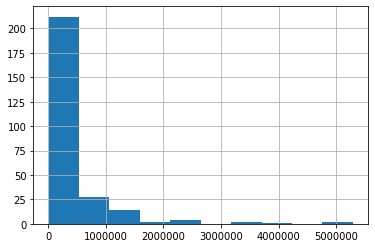

count    2.640000e+02
mean     4.307551e+05
std      6.611081e+05
min      6.144000e+03
25%      1.000960e+05
50%      2.373120e+05
75%      4.424960e+05
max      5.286262e+06
Name: length, dtype: float64

In [5]:
df['length'].hist()
plt.show()
df['length'].describe()

In [6]:
# We set window to 6.144000e+03 frames as it's the minimum length among our audio files
df['windows'] = df['length'].apply(lambda x: int(x/6.144000e+03))
df.head()

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license,length,windows
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/,256512.0,41
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/,52736.0,8
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/,47104.0,7
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/,152576.0,24
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/,94720.0,15


In [7]:
# We use 23 windows per genus to have a balanced data set

n_windows = df.groupby('species')['windows'].sum().min()
n_windows

20

In [8]:
# First we create all windows for each file and partition them by species

windows = {}

for file_id in df['file_id']:
    wave = waves[file_id]
    species = df[df['file_id']==file_id]['genus'].values[0] + "_" + df[df['file_id']==file_id]['species'].values[0]
    if species not in windows:
        windows[species] = []
    for i in range(0, int(len(wave)/6.144000e+03)):
        windows[species].append(wave[i:int(i+6.144000e+03)])

In [9]:
# We randomly pick 20 windows for each species

# Save other samples for testing

windows_fixed = {}
windows_fixed_test = {}

for species in windows.keys():
    windows_fixed[species] = []
    windows_fixed_test[species] = []
    ws = windows[species]
    index = np.random.choice(len(ws), n_windows, replace=False)
    for i in range(0, len(ws)):
        if i in index:
            windows_fixed[species].append(ws[i])
        else:
            windows_fixed_test[species].append(ws[i])

In [10]:
# Extract Features from Window
new_dataset = pd.DataFrame()

for species in windows_fixed.keys():
    for i in range(0,n_windows):
        data_point = {'species':species.split('_')[1], 'genus':species.split('_')[0]}
        spec_centroid = feature.spectral_centroid(windows_fixed[species][i])[0]
        chroma = feature.chroma_stft(windows_fixed[species][i], sample_rate)
        for j in range(0,13):
            data_point['spec_centr_'+str(j)] = spec_centroid[j]
            for k in range(0,12):
                data_point['chromogram_'+str(k)+"_"+str(j)] = chroma[k,j]
        new_dataset = new_dataset.append(data_point,ignore_index=True)

new_dataset.head()

C:\Users\patil\.conda\envs\librosa\lib\site-packages\librosa\core\pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


,chromogram_0_0,chromogram_0_1,chromogram_0_10,chromogram_0_11,chromogram_0_12,chromogram_0_2,chromogram_0_3,chromogram_0_4,chromogram_0_5,chromogram_0_6,...,spec_centr_12,spec_centr_2,spec_centr_3,spec_centr_4,spec_centr_5,spec_centr_6,spec_centr_7,spec_centr_8,spec_centr_9,species
0,1.000000,0.833207,0.770394,0.702116,0.655413,0.326867,0.922793,0.313101,0.493068,0.167065,...,2503.140943,2731.402739,2610.782378,2702.360640,2675.551167,2817.795126,2708.001038,2738.732677,2687.312293,flammea
1,0.991786,0.829836,0.769562,0.702360,0.658253,0.327552,0.923582,0.312167,0.492926,0.167125,...,2500.947915,2731.257282,2610.638981,2702.536770,2675.689443,2817.896605,2707.686054,2739.083012,2686.864795,flammea
2,0.986246,0.828101,0.767894,0.703366,0.664334,0.328939,0.925159,0.310319,0.492645,0.167255,...,2502.520326,2730.963584,2610.355897,2702.883833,2675.969849,2818.093899,2707.057771,2739.780883,2685.969365,flammea
3,1.000000,0.904057,0.749178,0.708311,0.676812,0.318977,0.899720,0.284723,0.506305,0.168488,...,2511.527083,2730.666135,2610.077567,2703.223986,2676.255549,2818.283778,2706.431852,2740.475066,2685.073256,flammea
4,0.997944,0.832392,0.765386,0.704274,0.655724,0.331064,0.927524,0.307601,0.492226,0.167480,...,2507.041444,2730.515996,2609.940118,2703.391485,2676.400501,2818.375970,2706.119792,2740.820762,2684.624946,flammea


In [11]:
# Extract Features from Window for test
new_dataset_test = pd.DataFrame()

for species in windows_fixed_test.keys():
    for i in range(0,len(windows_fixed_test[species])):
        data_point = {'species':species.split('_')[1], 'genus':species.split('_')[0]}
        spec_centroid = feature.spectral_centroid(windows_fixed_test[species][i])[0]
        chroma = feature.chroma_stft(windows_fixed_test[species][i], sample_rate)
        for j in range(0,13):
            data_point['spec_centr_'+str(j)] = spec_centroid[j]
            for k in range(0,12):
                data_point['chromogram_'+str(k)+"_"+str(j)] = chroma[k,j]
        new_dataset_test = new_dataset_test.append(data_point,ignore_index=True)

new_dataset_test.head()

C:\Users\patil\.conda\envs\librosa\lib\site-packages\librosa\core\pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


,chromogram_0_0,chromogram_0_1,chromogram_0_10,chromogram_0_11,chromogram_0_12,chromogram_0_2,chromogram_0_3,chromogram_0_4,chromogram_0_5,chromogram_0_6,...,spec_centr_12,spec_centr_2,spec_centr_3,spec_centr_4,spec_centr_5,spec_centr_6,spec_centr_7,spec_centr_8,spec_centr_9,species
0,1.000000,0.945011,0.749241,0.714737,0.704973,0.311386,0.881971,0.280575,0.519973,0.170108,...,2486.230223,2731.690858,2611.073052,2702.003237,2675.278369,2817.586461,2708.632709,2738.029236,2688.206943,flammea
1,0.650246,0.590960,0.712450,0.909644,0.727013,0.502476,1.000000,0.242925,0.337245,0.167843,...,2502.704268,2731.547262,2610.927073,2702.182796,2675.414148,2817.691756,2708.316600,2738.381425,2687.759668,flammea
2,0.982724,0.826883,0.768728,0.702757,0.662904,0.328242,0.924370,0.311240,0.492785,0.167188,...,2501.371362,2731.110899,2610.496832,2702.711164,2675.828998,2817.996191,2707.371616,2739.432406,2686.417157,flammea
3,1.000000,0.945205,0.744401,0.716860,0.701898,0.315170,0.885456,0.275877,0.519047,0.170131,...,2503.521700,2730.815330,2610.216161,2703.054782,2676.112023,2818.189760,2706.744520,2740.128440,2685.521406,flammea
4,1.000000,0.897269,0.747530,0.708578,0.671679,0.320334,0.901020,0.283132,0.506009,0.168585,...,2499.849518,2730.364910,2609.803780,2703.557255,2676.546950,2818.466349,2705.808330,2741.165513,2684.176450,flammea


In [12]:
# Prepare dataset to fit a simple model

features= list(new_dataset.columns)
features.remove('species')
features.remove('genus')

X = new_dataset[features].values
y = new_dataset['species'].values

X_test = new_dataset_test[features].values
y_test = new_dataset_test['species'].values

In [13]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)   
SSS = sklearn.model_selection.StratifiedShuffleSplit(n_splits=5, test_size=0.2)

accs = [] 

for train_index, val_index in SSS.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_val)
    
    accs.append(sklearn.metrics.accuracy_score(y_pred=y_pred, y_true=y_val))
    
print(accs)

[0.9403409090909091, 0.9403409090909091, 0.9346590909090909, 0.9431818181818182, 0.9318181818181818]


In [14]:
print("Training accuracy is ",knn.score(X_train,y_train)) 
print("Test accuracy is ", knn.score(X_test,y_test)) 

Training accuracy is  0.9786931818181818
Test accuracy is  0.9047876819439432


In [15]:
y_pred = knn.predict(X_test)
sklearn.metrics.accuracy_score(y_pred=y_pred, y_true=y_test)

0.9047876819439432

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 77   0   0 ...   0   0   2]
 [  0  16   0 ...   0   0   0]
 [  0   0 228 ...   0   0   0]
 ...
 [  0   0   0 ...  95   0   0]
 [  0   0   0 ...   0  24   0]
 [  0   0   0 ...   0   0  37]]
               precision    recall  f1-score   support

       aguimp       1.00      0.90      0.94        86
       alpina       0.57      0.94      0.71        17
        aluco       1.00      1.00      1.00       228
     apiaster       1.00      0.82      0.90       115
     apivorus       0.39      0.99      0.56        77
    apricaria       0.96      0.90      0.93       276
         apus       0.99      0.95      0.97       526
   argentatus       0.81      1.00      0.89       102
     arvensis       0.97      0.77      0.86      1711
         ater       0.79      1.00      0.88       142
         atra       1.00      0.80      0.89        40
  atricapilla       0.75      0.87      0.80       136
        borin       0.87      0.84      0.85       280
    caeruleus       1.00      0.96   